# Unstructured Voronoi Grids and Applications in Atmospheric Dynamics on the Sphere

---



## Introduction and motivation

The two dominant grids currently used in modern atmospheric models are the ones based on Voronoi grids and the ondes based on Cubed Sphere grids.

Here, we will discuss what is a Voronoi grid, and its duality with the Delauney triangulation. We will start with 2D mesh constructions and then move towards grids on the sphere.

We highligh that MPAS uses spherical Voronoi grids, so understanding the grid structure is a key part of understanding the model.



---



In [ ]:
import numpy as np
import matplotlib.pyplot as plt




## 2D Triangulation

Let's start with an arbitrary set of points on the plane. For instance

In [ ]:
points = np.array([[0.5, 0.5], [0.2, 0.35], [0.15, 0.7], [0.85, 0.22], [0.8, 0.8], [0.5, 0.15], [0.5, 0.85]])

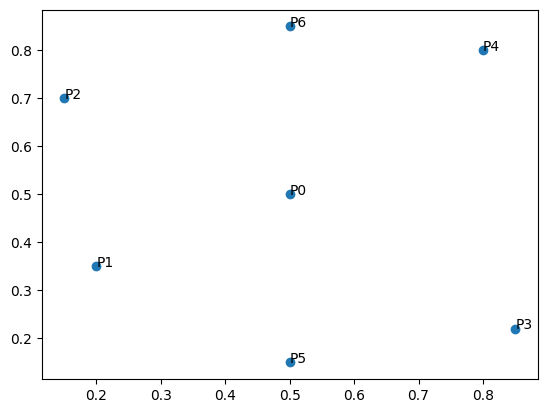

In [ ]:
plt.plot(points[:,0], points[:,1], 'o')
names = ["P"+str(i) for i in range(len(points))]
for i, name in enumerate(names):
  plt.text(points[i,0], points[i,1], name) #, names)

plt.show()


The question now is: how can we connect these points to form triangles?




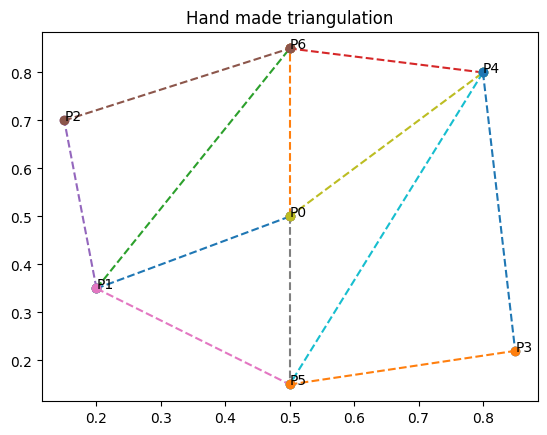

In [ ]:
#P0-P1
plt.plot(points[[0,1],0], points[[0,1],1], 'o', linestyle="--")
#P0-P6
plt.plot(points[[0,6],0], points[[0,6],1], 'o', linestyle="--")
#P1-P6
plt.plot(points[[1,6],0], points[[1,6],1], 'o', linestyle="--")
#P4-P6
plt.plot(points[[4,6],0], points[[4,6],1], 'o', linestyle="--")
#P1-P2
plt.plot(points[[1, 2],0], points[[1, 2],1], 'o', linestyle="--")
#P2-P6
plt.plot(points[[2,6],0], points[[2,6],1], 'o', linestyle="--")
#P1-P5
plt.plot(points[[1,5],0], points[[1,5],1], 'o', linestyle="--")
#P0-P5
plt.plot(points[[0,5],0], points[[0,5],1], 'o', linestyle="--")
#P0-P5
plt.plot(points[[0,4],0], points[[0,4],1], 'o', linestyle="--")
#P4-P5
plt.plot(points[[4,5],0], points[[4,5],1], 'o', linestyle="--")
#P4-P3
plt.plot(points[[4,3],0], points[[4,3],1], 'o', linestyle="--")
#P5-P3
plt.plot(points[[5,3],0], points[[5,3],1], 'o', linestyle="--")

names = ["P"+str(i) for i in range(len(points))]
for i, name in enumerate(names):
  plt.text(points[i,0], points[i,1], name) #, names)

plt.title("Hand made triangulation")
plt.show()

👉 Is this a good grid?

Which grid generates triangles closer to equilateral? (More regular grid)?

We want to avoid triangles with angles too small, or too large.


⭐ **Delaunay triangulation**: Given a set of points, the Delaunay triangle is given by the triangulation such that no point of the set is inside the circumcircle of any triangle of the triangulation.

Delaunay triangulations maximize the minimum of all the angles of the triangles in the triangulation; they tend to avoid sliver triangles (those with very acute angles).

Lets see if our triangulation was a Delaunay triangulation:

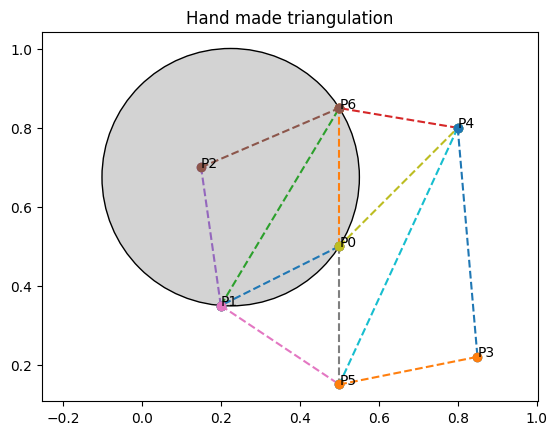

In [ ]:
fig, ax = plt.subplots()
#P0-P1
plt.plot(points[[0,1],0], points[[0,1],1], 'o', linestyle="--")
#P0-P6
plt.plot(points[[0,6],0], points[[0,6],1], 'o', linestyle="--")
#P1-P6
plt.plot(points[[1,6],0], points[[1,6],1], 'o', linestyle="--")
#P4-P6
plt.plot(points[[4,6],0], points[[4,6],1], 'o', linestyle="--")
#P1-P2
plt.plot(points[[1, 2],0], points[[1, 2],1], 'o', linestyle="--")
#P2-P6
plt.plot(points[[2,6],0], points[[2,6],1], 'o', linestyle="--")
#P1-P5
plt.plot(points[[1,5],0], points[[1,5],1], 'o', linestyle="--")
#P0-P5
plt.plot(points[[0,5],0], points[[0,5],1], 'o', linestyle="--")
#P0-P5
plt.plot(points[[0,4],0], points[[0,4],1], 'o', linestyle="--")
#P4-P5
plt.plot(points[[4,5],0], points[[4,5],1], 'o', linestyle="--")
#P4-P3
plt.plot(points[[4,3],0], points[[4,3],1], 'o', linestyle="--")
#P5-P3
plt.plot(points[[5,3],0], points[[5,3],1], 'o', linestyle="--")

names = ["P"+str(i) for i in range(len(points))]
for i, name in enumerate(names):
  plt.text(points[i,0], points[i,1], name) #, names)

def circle3Points(b, c, d):
  temp = c[0]**2 + c[1]**2
  bc = (b[0]**2 + b[1]**2 - temp) / 2
  cd = (temp - d[0]**2 - d[1]**2) / 2
  det = (b[0] - c[0]) * (c[1] - d[1]) - (c[0] - d[0]) * (b[1] - c[1])

  if abs(det) < 1.0e-10:
    return None

  # Center of circle
  cx = (bc*(c[1] - d[1]) - cd*(b[1] - c[1])) / det
  cy = ((b[0] - c[0]) * cd - (c[0] - d[0]) * bc) / det

  radius = ((cx - b[0])**2 + (cy - b[1])**2)**.5

  return radius, cx, cy

from matplotlib.patches import Circle

#Circle with points P0, P1, P6
radius, cx, cy = circle3Points(points[0,:], points[1,:], points[6,:])
center = (cx, cy)
circle = Circle(center, radius, facecolor='lightgrey', edgecolor='black')
ax.add_patch(circle)
plt. axis('equal')
plt.title("Hand made triangulation")
plt.show()

No! Our triangulation is not Delaunay, since P2 is inside circle formed by P0, P1, P6!!!



---





Building Delaunay triangulations involves some complex geometric algorithms, that we will not go into details here.

Here, we will use the Scipy algorithm, which looks for a simplex (a triangulation) that matches the Delaunay criteria:

https://docs.scipy.org/doc/scipy/reference/spatial.html

In [ ]:
from scipy.spatial import Voronoi, Delaunay, voronoi_plot_2d
points = np.array([[0.5, 0.5], [0.2, 0.35], [0.15, 0.7], [0.85, 0.22], [0.8, 0.8], [0.5, 0.15], [0.5, 0.85]])

tri = Delaunay(points)

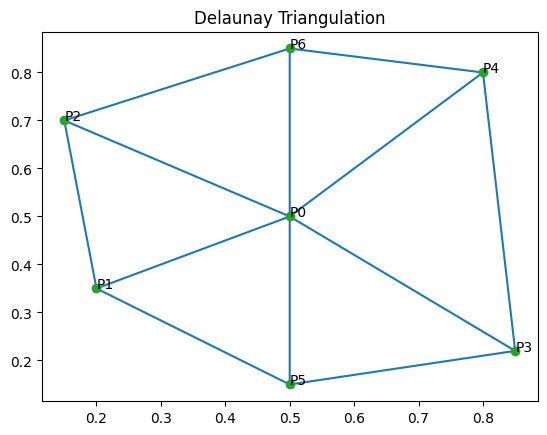

In [ ]:
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
names = ["P"+str(i) for i in range(len(points))]
for i, name in enumerate(names):
  plt.text(points[i,0], points[i,1], name) #, names)
plt.title("Delaunay Triangulation")
plt.show()

Let's check if this is really Delaunay:


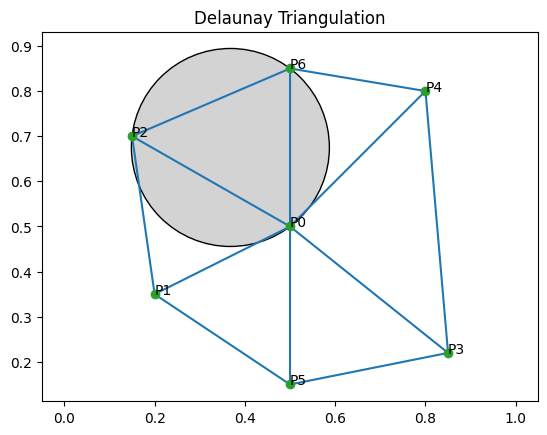

In [ ]:
fig, ax = plt.subplots()

def circle3Points(b, c, d):
  temp = c[0]**2 + c[1]**2
  bc = (b[0]**2 + b[1]**2 - temp) / 2
  cd = (temp - d[0]**2 - d[1]**2) / 2
  det = (b[0] - c[0]) * (c[1] - d[1]) - (c[0] - d[0]) * (b[1] - c[1])

  if abs(det) < 1.0e-10:
    return None

  # Center of circle
  cx = (bc*(c[1] - d[1]) - cd*(b[1] - c[1])) / det
  cy = ((b[0] - c[0]) * cd - (c[0] - d[0]) * bc) / det

  radius = ((cx - b[0])**2 + (cy - b[1])**2)**.5

  return radius, cx, cy

from matplotlib.patches import Circle



#Circle with points P0, P1, P6
radius, cx, cy = circle3Points(points[0,:], points[2,:], points[6,:])
center = (cx, cy)
circle = Circle(center, radius, facecolor='lightgrey', edgecolor='black')
ax.add_patch(circle)
plt. axis('equal')

names = ["P"+str(i) for i in range(len(points))]
for i, name in enumerate(names):
  plt.text(points[i,0], points[i,1], name) #, names)
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')

plt.title("Delaunay Triangulation")
plt.show()


Behing the scenes:
(base on wikipedia https://en.wikipedia.org/wiki/Delaunay_triangulation)

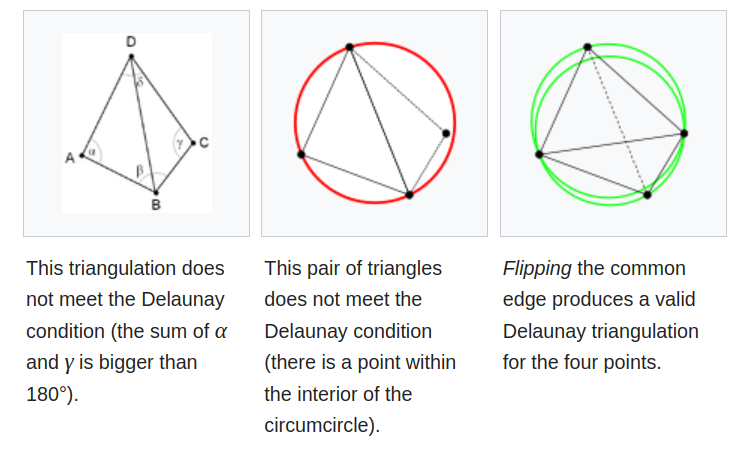

## 2D Voronoi Tesselations

Lets consider the same set of points.

In [ ]:
points = np.array([[0.5, 0.5], [0.2, 0.35], [0.15, 0.7], [0.85, 0.22], [0.8, 0.8], [0.5, 0.15], [0.5, 0.85]])

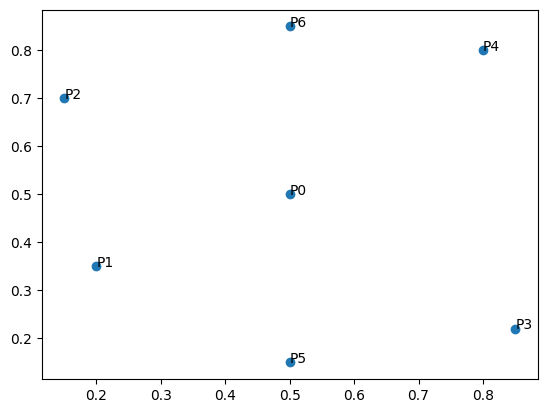

In [ ]:
plt.plot(points[:,0], points[:,1], 'o')
names = ["P"+str(i) for i in range(len(points))]
for i, name in enumerate(names):
  plt.text(points[i,0], points[i,1], name) #, names)

plt.show()


But now, we ask for a different griding related to there points:

⭐ **Voronoi Tesselation/Diagram**: Given a set of generator points, which we will call nodes, we subdivide the planar regions (cells), with one cell for each point under the following criteria: the cell for a given node is formed by the subset of the plane that contains points closer to the reference node than any other node.

👉 Analogy: Let's say we have a set of schools at given locations. The Voronoi diagram would basically say, based on where the student lives, which school he/she should go, in order to be closer to the school.

We will use Scipy to construct Voronoi Diagrams, but it is not dificult to build it using the circuncenters of the Delaunay triangulation.

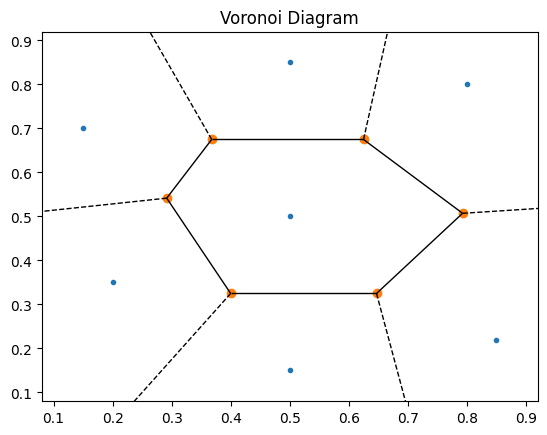

In [ ]:
from scipy.spatial import Voronoi, Delaunay, voronoi_plot_2d

vor = Voronoi(points)
fig = voronoi_plot_2d(vor)
plt.title("Voronoi Diagram")
plt.show()

In [ ]:
def plotDelVor(points):
  vor = Voronoi(points)
  tri = Delaunay(points)
  figsize=(10, 10)
  fig, ax = plt.subplots(1,1,figsize=figsize)
  ax.triplot(points[:,0], points[:,1], tri.simplices)
  ax.plot(points[:,0], points[:,1], 'o')
  fig = voronoi_plot_2d(vor, ax = ax, line_colors='red', line_width=2, line_alpha=0.6, point_size=2)
  plt.title("Voronoi (red), Delaunay (blue)")

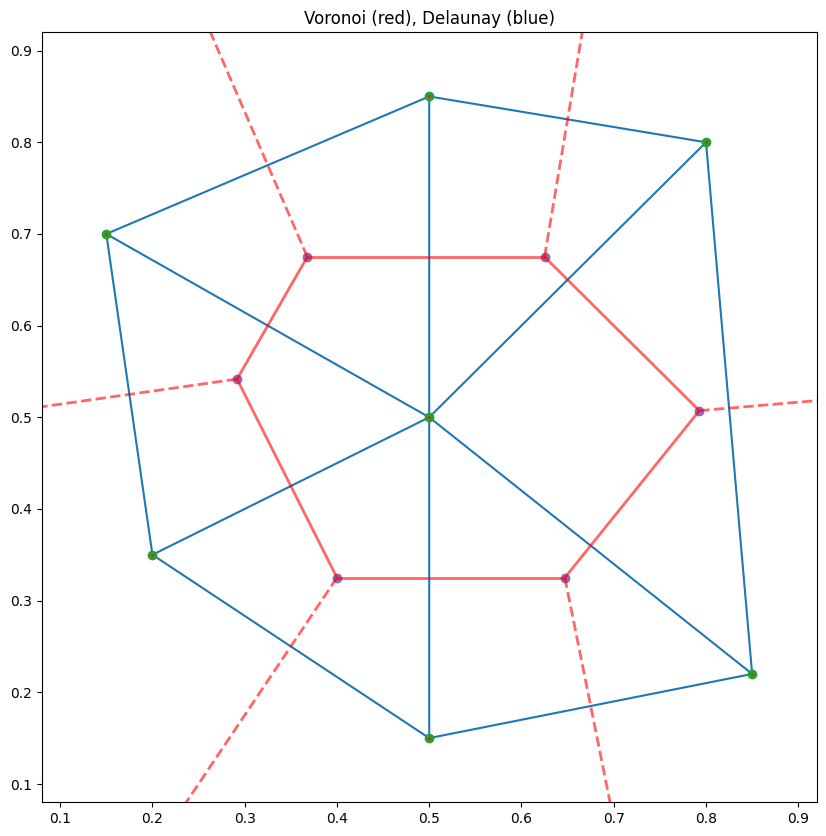

In [ ]:
plotDelVor(points)

Let's look into more details about Voronoi Diagrams and Delaunay Triangulations:

* Given 2 nodes, the limit of the Voronoi cell between these nodes (red) is exactly at the midpoint of the respective Delaunay edge (blue). This is a consequencia of the definition of Voronoi region.
* The Voronoi edges (red) are perpendicular to the Delaunay edges (blue). This is a consequence of the Orthogonality Theorem (Pitagorean) and the definition of Voronoi Diagram.
* The vertices of a Voronoi cell are circuncenters of the Delaunay triangles. This is a consequence of the circuncenter being a point equidistant from the nodes.
* Delaunay triangles may not be unique, for instance when respective Voronoi diagrams are squares (see bellow).


Let's check some other Triangulations/Diagrams:

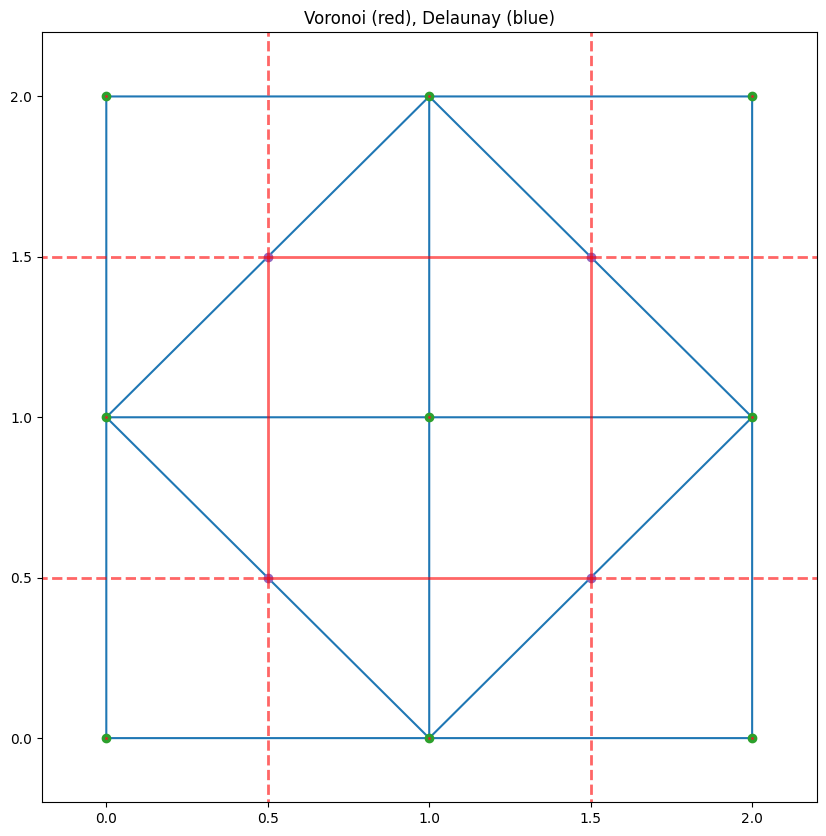

In [ ]:
points = np.array([[0, 0], [0, 1], [0, 2], [1, 0], [1, 1], [1, 2],
                   [2, 0], [2, 1], [2, 2]])

plotDelVor(points)

Triangles with 90 degree angles! This creates a non-unique Delaunay triangulation. However, the Voronoi Diagrams are unique and well defined.



---



Some examples in nature:

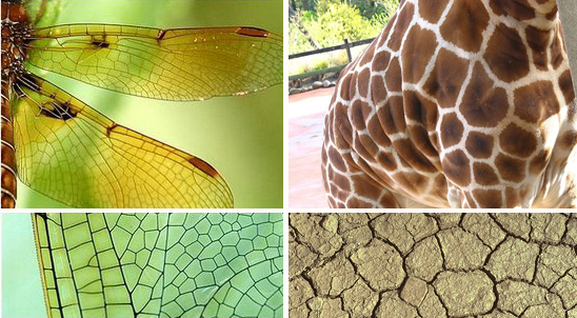

https://teamhoudini.wordpress.com/2018/12/06/camilla-voronoi-diagram-knowledge-analysis-in-nature/

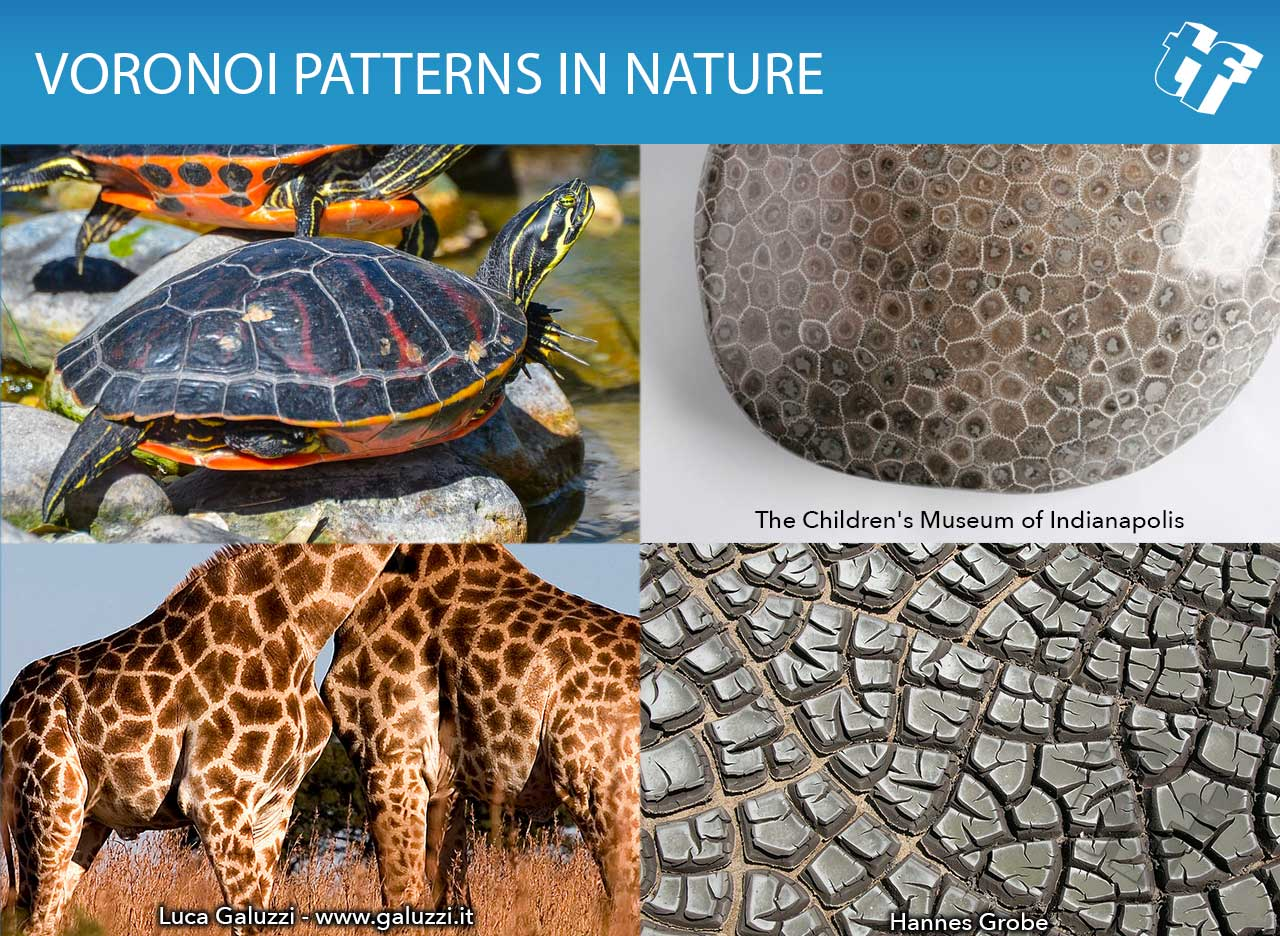

https://www.sciencedirect.com/science/article/pii/S0167732221012770#f0005

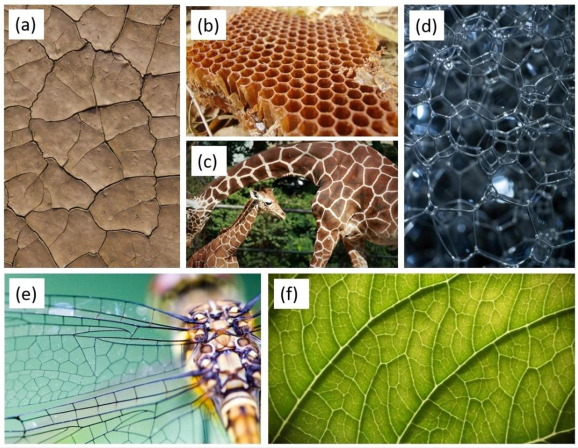



---



## Spherical Voronoi Diagrams

If we change the domain to the spherical domain, triangles are now spherical triangles, and Voronoi regions are now sub-sets of the sphere.

All concepts discussed before are still valid, now on the sphere, with some care about the defining the distance metric now as the geodesic distance on the sphere (for Voronoi regions).

### The cubed sphere grid

A first example is the case with 6 points uniformelly spaced on the sphere. The associated Voronoi diagram in this case generates the cubed sphere. Let's see bellow an example, using a Scipy tool.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.SphericalVoronoi.html

In [ ]:
from scipy.spatial import SphericalVoronoi, geometric_slerp
from mpl_toolkits.mplot3d import proj3d, Axes3D


In [ ]:
def plotVorSph(points):

  radius = 1
  center = np.array([0, 0, 0])
  sv = SphericalVoronoi(points, radius, center)
  # sort vertices (optional, helpful for plotting)
  sv.sort_vertices_of_regions()


  figsize=(10, 10)
  fig = plt.figure(figsize=figsize)
  ax = fig.add_subplot(111, projection='3d')


  # plot the unit sphere for reference (optional)
  u = np.linspace(0, 2 * np.pi, 100)
  v = np.linspace(0, np.pi, 100)
  x = np.outer(np.cos(u), np.sin(v))
  y = np.outer(np.sin(u), np.sin(v))
  z = np.outer(np.ones(np.size(u)), np.cos(v))
  ax.plot_surface(x, y, z, color='y', alpha=0.05)

  # plot generator points
  ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='blue', marker='.')

  # plot Voronoi vertices
  ax.scatter(sv.vertices[:, 0], sv.vertices[:, 1], sv.vertices[:, 2],  c='gray', marker='.')

  # indicate Voronoi regions (as Euclidean polygons)
  t_vals = np.linspace(0, 1, 2000)
  for region in sv.regions:
    n = len(region)
    for i in range(n):
        start = sv.vertices[region][i]
        end = sv.vertices[region][(i + 1) % n]
        result = geometric_slerp(start, end, t_vals)
        ax.plot(result[..., 0], result[..., 1], result[..., 2], c='gray', linestyle='--', linewidth = 1)

  ax.azim = 10
  ax.elev = 10
  ax.set_xlabel("x")
  ax.set_ylabel("y")
  ax.set_zlabel("z")
  ax.set_aspect('equal')
  plt.show()

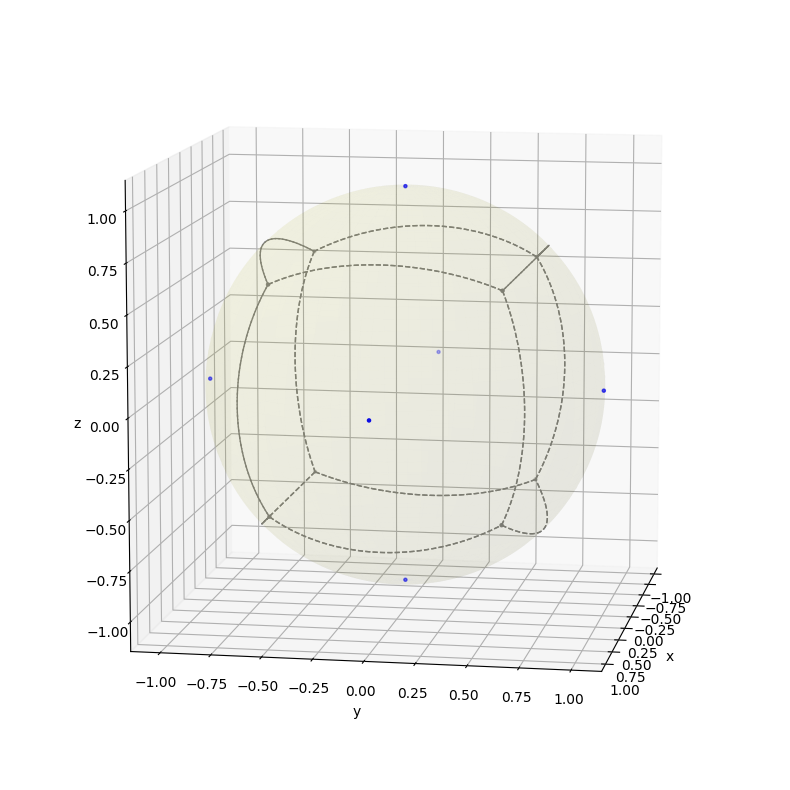

In [ ]:
points = np.array([[0, 0, 1], [0, 0, -1], [1, 0, 0],
                   [0, 1, 0], [0, -1, 0], [-1, 0, 0], ])

plotVorSph(points)

This is the cubed sphere!




---



### Icosahedral Grid

The basis for the constructions used in models such as MPAS is an icosahedral grid. Let's see how this looks like.

This package just provides the points on the sphere refering icosahedral corners:
https://pypi.org/project/icosphere/

In [ ]:
!pip install icosphere

  Preparing metadata (setup.py) ... done
  Created wheel for icosphere: filename=icosphere-0.1.3-py3-none-any.whl size=15096 sha256=5f83e4ef7db70078d4d88c081d56e6b29bf9286ea86a83db1b1c37e61d16308e
  Stored in directory: /root/.cache/pip/wheels/7e/cd/71/42212db7d97ea059e9d54e7dee1e11e163e92e087574833d3c
Successfully built icosphere


In [ ]:
from icosphere import icosphere
nu = 3  # Number of partitions of basic icosahedron
vertices, faces = icosphere(nu)

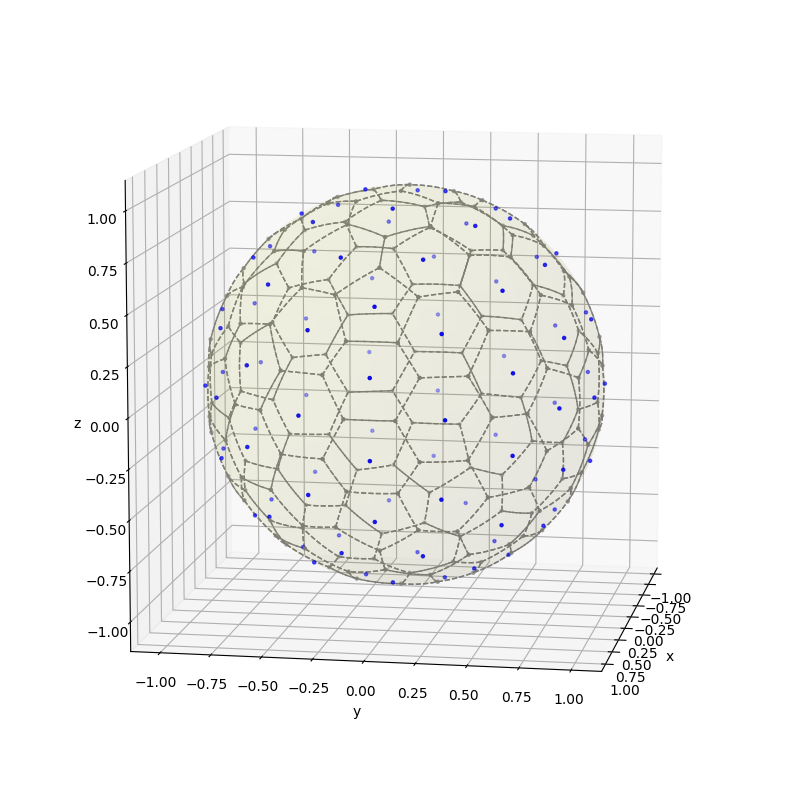

In [ ]:
plotVorSph(vertices)

## ❗Exercise ❗

1. Consider 6 distinct points on the plane in the following way:
 - One point ($p_0$) lays in the centre of the domain (let's say, at coordinate $(0,0)$)
 - The other 5 points all have an Euclidean distance of 1 to the central point, that is $\|p_i-p_0\| = 1$, but are disposed arbitrarily around the central point.

  Construct the Delaunay Triangulation and the Voronoi diagram of this set of points.


---


2.   Consider the following set of points on the sphere:

North and South poles:
$$(0,0,1)  $$
$$(0,0,-1)  $$

Points at the equator:
$$(\cos(k \pi/3) ,\sin(k \pi/3), 0) , \quad k=0,1,2,3,4,5 $$

a. Plot the Voronoi diagram associated with this set of points on the sphere and discuss the shape of the cells at North and South poles.

b. What happens if you add another point on the sphere that is not at the equator?



---

